In [1]:
import yaml
import h5py
import numpy as np
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import nibabel as nib
import pandas as pd
from IPython.display import clear_output
from skimage.segmentation import find_boundaries

In [2]:
def load3D_metadata(path):
    # Dictionary with information from the image
    dim_info = {}

    # Load image, but not physically in the RAM
    proxy = nib.load(path)

    # Metadata
    dim_info["x_size"] = proxy.header["dim"][1]
    dim_info["y_size"] = proxy.header["dim"][2]
    dim_info["z_size"] = proxy.header["dim"][3]

    # [u. distancia/pixel]
    dim_info["x_res"] = np.round(proxy.header["pixdim"][1], 6)
    dim_info["y_res"] = np.round(proxy.header["pixdim"][2], 6)
    dim_info["z_res"] = np.round(proxy.header["pixdim"][3], 6)

    return dim_info

In [7]:
line_path = "/Users/dvarelat/Documents/MASTER/TFM/DATA/LINES/line_20190401_E2.nii.gz"
decon_nuclei = "/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/DAPI/20190401_E2_DAPI_decon_0.5.nii.gz"
decon_memb = "/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/MGFP/20190401_E2_mGFP_decon_0.5.nii.gz"

In [8]:
decon = nib.load(decon_nuclei).get_fdata()
decon = decon[:,:,:,0]
decon.shape

(1024, 1024, 566)

In [12]:
deconmem = nib.load(decon_memb).get_fdata()
deconmem = deconmem[:,:,:,0]
deconmem.shape

(1024, 1024, 566)

In [13]:
proxy_img_line = nib.load(line_path)  # File with all lines
line = proxy_img_line.get_data()

/var/folders/bt/7wh6kgqj5dj7b4nzk088_fm5g8zk0t/T/ipykernel_27522/3396691342.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  line = proxy_img_line.get_data()


In [10]:
line.shape

(1024, 1024, 566)

150


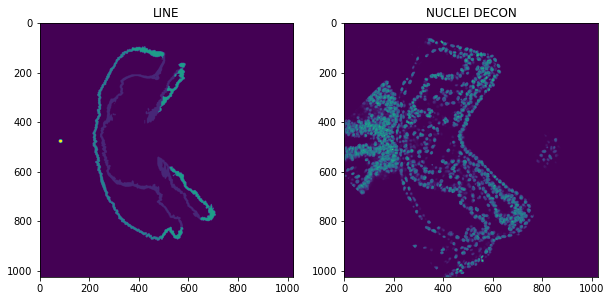

In [9]:
for t in range(50):
    plt.figure(figsize=(10,10)) 
    n = 150 #10*t
    print(n)
    plots = [line[:, :, n], decon[:, :, n]]
    titles = ["LINE", "NUCLEI DECON"]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1).set_title(titles[i]) 
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)
    break

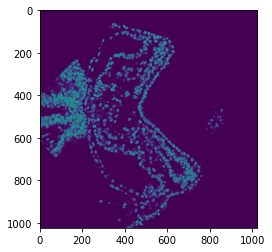

In [14]:
array_zxy = np.swapaxes(np.swapaxes(decon, 0, 2), 1, 2)
plt.imshow(array_zxy[150,:,:])

In [15]:
dim_info_line = load3D_metadata(line_path)

In [16]:
dim_info_line

{'x_size': 1024,
 'y_size': 1024,
 'z_size': 566,
 'x_res': 0.853671,
 'y_res': 0.853671,
 'z_res': 0.99691}

In [12]:
# Rectangulo 3D en el que se abarca la zona cardiaca
# Esta en las unidades de las imagenes de 2048x2048
# ([x_ini, y_ini, z_ini], [x_fin, y_fin, z_fin])

In [17]:
todas_las_coordenadas_de_la_linea = np.where(line > 0)

In [18]:
for i in todas_las_coordenadas_de_la_linea:
    print(i.shape)
todas_las_coordenadas_de_la_linea[1]

(11508657,)
(11508657,)
(11508657,)


array([477, 477, 477, ..., 599, 600, 600])

In [65]:
margenes_zona_cardiaca = (
        np.min(todas_las_coordenadas_de_la_linea, axis=1),
        np.max(todas_las_coordenadas_de_la_linea, axis=1),
    )
margenes_zona_cardiaca

(array([44, 24, 26]), array([905, 904, 466]))

### CAMBIO ESCALA: de LINE a la escala de la imagen de 2048

In [53]:
file_ ="/Users/dvarelat/Documents/MASTER/TFM/notebooks/testdata/20190401_E2_DAPI_x1116to1352_y315to551_z337to539_decon.nii.gz"
#file = "/Users/dvarelat/Documents/MASTER/TFM/DATA/20190401_E2_down/20190401_E2_DAPI_decon_0.5.nii.gz"

proxy = nib.load(file_)
print(proxy.header["pixdim"][1], proxy.header["pixdim"][2], proxy.header["pixdim"][3])

0.426835 0.426835 0.498455


In [55]:
margenes_zona_cardiaca

(array([44, 24, 26]), array([905, 904, 466]))

In [51]:
dim_info = load3D_metadata(file_)
dim_info

{'x_size': 236,
 'y_size': 236,
 'z_size': 202,
 'x_res': 0.426835,
 'y_res': 0.426835,
 'z_res': 0.498455}

In [66]:
margenes_zona_cardiaca[0][0] *= dim_info_line["x_res"] / dim_info["x_res"]
margenes_zona_cardiaca[0][1] *= dim_info_line["y_res"] / dim_info["y_res"]
margenes_zona_cardiaca[0][2] *= dim_info_line["z_res"] / dim_info["z_res"]

margenes_zona_cardiaca[1][0] *= dim_info_line["x_res"] / dim_info["x_res"]
margenes_zona_cardiaca[1][1] *= dim_info_line["y_res"] / dim_info["y_res"]
margenes_zona_cardiaca[1][2] *= dim_info_line["z_res"] / dim_info["z_res"]

In [67]:
margenes_zona_cardiaca

(array([88, 48, 52]), array([1810, 1808,  932]))

In [68]:
ma = 25  # margen ampliacion
for i in range(2):
    margenes_zona_cardiaca[0][i] = (
        margenes_zona_cardiaca[0][i] - ma
        if margenes_zona_cardiaca[0][i] - ma > 0
        else 0
    )
    margenes_zona_cardiaca[1][i] = (
        margenes_zona_cardiaca[1][i] + ma
        if margenes_zona_cardiaca[1][i] + ma < 2048
        else 2048
    )
    margenes_zona_cardiaca[0][2] = (
    margenes_zona_cardiaca[0][2] - ma
    if margenes_zona_cardiaca[0][2] - ma > 0
    else 0
    )
    margenes_zona_cardiaca[1][2] = (
    margenes_zona_cardiaca[1][2] + ma
    if margenes_zona_cardiaca[1][2] + ma < 566*2
    else 566*2
    )

In [71]:
margenes_zona_cardiaca[0]
margenes_zona_cardiaca[1]

array([1835, 1833,  982])

## TESTING: dejarlo 05

In [19]:
margenes_zona_cardiaca_05 = (
        np.min(todas_las_coordenadas_de_la_linea, axis=1),
        np.max(todas_las_coordenadas_de_la_linea, axis=1),
    )
margenes_zona_cardiaca_05

(array([44, 24, 26]), array([905, 904, 466]))

In [20]:
ma = 5  # margen ampliacion
for i in range(2):
    margenes_zona_cardiaca_05[0][i] = (
        margenes_zona_cardiaca_05[0][i] - ma
        if margenes_zona_cardiaca_05[0][i] - ma > 0
        else 0
    )
    margenes_zona_cardiaca_05[1][i] = (
        margenes_zona_cardiaca_05[1][i] + ma
        if margenes_zona_cardiaca_05[1][i] + ma < 1024
        else 2048
    )
    margenes_zona_cardiaca_05[0][2] = (
    margenes_zona_cardiaca_05[0][2] - ma
    if margenes_zona_cardiaca_05[0][2] - ma > 0
    else 0
    )
    margenes_zona_cardiaca_05[1][2] = (
    margenes_zona_cardiaca_05[1][2] + ma
    if margenes_zona_cardiaca_05[1][2] + ma < 566
    else 566
    )
margenes_zona_cardiaca_05

(array([39, 19, 16]), array([910, 909, 476]))

In [30]:
crop = line.copy()


In [31]:
#delimiter = line + crop
delimiter = find_boundaries(crop)
delimiter = crop + delimiter*10

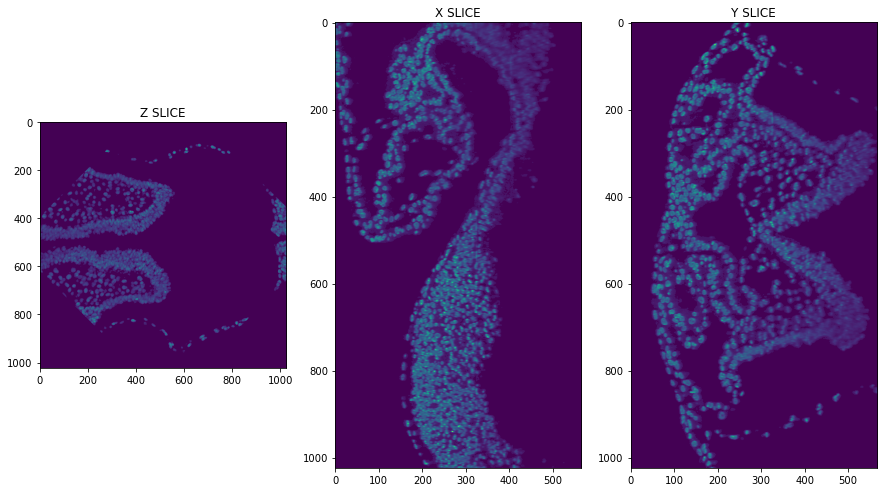

In [32]:
for t in range(50):
    plt.figure(figsize=(15,15)) 
    n = 10*t
    plots = [delimiter[:, :, n], delimiter[n, :, :], delimiter[:, n, :]]
    titles = ["Z SLICE", "X SLICE", "Y SLICE"]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1).set_title(titles[i]) 
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)